<a href="https://colab.research.google.com/github/Azuremis/make_your_first_gan_with_pytorch/blob/master/human_face_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Human face generation using celebA dataset

In [1]:
# mount drive to read data files
from google.colab import drive
drive.mount("./mount")

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

CUDA check and setup

In [3]:
# check for cuda availability 
if torch.cuda.is_available():  # if cuda available
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # make default tensor type to cuda tensor
    print("using cuda:", torch.cuda.get_device_name(0))  # show the device name

# sets up device for easier data movement to GPU (if not the deafult)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

CelebA Dstaset class

In [4]:
class CelebADataset(Dataset):
  
    def __init__(self, hdf5_file):
        self.file_object = h5py.File(hdf5_file, "r", swmr=True) 
        self.dataset = self.file_object["img_align_celeba"]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if index >= len(self.dataset):
            raise IndexError()
        
        # normalise image data
        img = np.array(self.dataset[str(index) + ".jpg"])

        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(np.array(self.dataset[str(index) + ".jpg"]), interpolation="None")

In [5]:
celeba_dataset = CelebADataset("mount/My Drive/Colab Notebooks/make_your_first_gan_with_pytorch/celeba_data/celeba_aligned_samll.h5py")

In [6]:
print(len(celeba_dataset))

20000


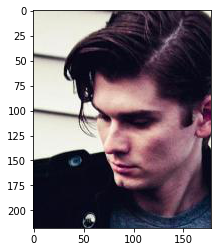

In [7]:
celeba_dataset.plot_image(11131)

In [8]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

CelebA discriminator

In [9]:
# set up the discriminator
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # set up nn layers
        self.model = nn.Sequential(
            View(218*178*3),  # reshape the 3d image tensor to 1d tensor of shape (218*178*3)
            nn.Linear(218*178*3, 100),
            nn.LeakyReLU(),  # reduce vanishing gradient issue for large signal values
            nn.LayerNorm(100),  # normalise signals to avoid network saturation from large values
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        # set up loss
        self.loss_function = nn.BCELoss()  # BCELoss better for classification tasks

        # set up optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # set up progress monitors
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # just run the model
        return self.model(inputs)

    def train(self, inputs, targets):
        # calculate predictions
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # track training progress
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())  # accumulate error
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass by calcuating gradients
        loss.backward()
        # update learnable parameters
        self.optimiser.step()

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=["loss"])    
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


Testing the discriminator

In [10]:
# generates random image
def generate_random_image(size):
    # uniformly distributed data is best for random image
    return torch.rand(size) 

In [11]:
%%time

discrim = Discriminator()

# move model to cuda device
discrim.to(device)

for image_data_tensor in celeba_dataset:
    # train with real data
    discrim.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # train with fake data
    discrim.train(generate_random_image((218, 178, 3)), torch.cuda.FloatTensor([0.0]))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 3min 1s, sys: 57.5 s, total: 3min 58s
Wall time: 4min


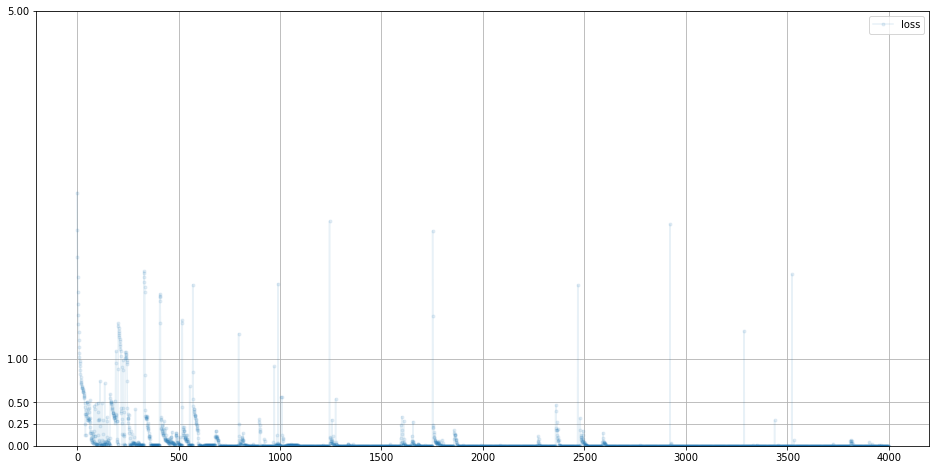

In [15]:
# plot model loss
discrim.plot_progress()

In [19]:
# manual run to check discriminitor is working
for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0, 20000)]
    print(discrim.forward(image_data_tensor).item())

for i in range(4):
    print(discrim.forward(generate_random_image(((218, 178, 3)))).item())


0.9995725750923157
0.9550204277038574
0.9988417029380798
0.9960108995437622
4.1406688978895545e-05
4.076950790476985e-05
4.3287942389724776e-05
4.150338645558804e-05


CelebA generator

In [21]:
class Generator(nn.Module):
    
    def __init__(self):
        # call parent pytorch class
        super().__init__()

        # set up layers
        self.model = nn.Sequential(
            nn.Linear(100, 300),
            nn.LeakyReLU(),  
            nn.LayerNorm(300),  
            nn.Linear(300, 218*178*3),
            nn.Sigmoid(),
            View((218, 178, 3))
        )

        # set up optimiser
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # set up progress tracking
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, discriminator, inputs, targets):
        # calculate network outputs, i.e. generate data
        generator_output = self.forward(inputs)

        # pass generated data to discriminator for classification
        discriminator_output = discriminator.forward(generator_output)

        # calculate loss using discriminator
        loss = discriminator.loss_function(discriminator_output, targets)

        # track generator loss
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        # zero gradients
        self.optimiser.zero_grad()
        # perform backward pass
        loss.backward()
        # update the parameters
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".",
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

Checking generator output

In [22]:
def generate_random_seed(size):
    # normalised dist is best for generator seed values 
    return torch.randn(size)

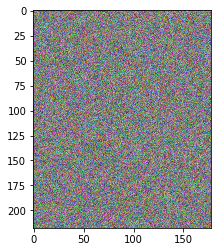

In [23]:
# check that generated data is right type and shape
seed = generate_random_seed(100)
gener = Generator()

# move model to cuda device
gener.to(device)

output = gener.forward(seed)
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation="none", cmap="Blues")

Training the GAN

In [30]:
%%time

# create discriminator and generator
Dis = Discriminator()
Dis.to(device)
Gen = Generator()
Gen.to(device)

# train discriminator and generator

epochs = 6

for i in range(epochs):
        
    for image_data_tensor in celeba_dataset:

        # train the discriminator on real data
        Dis.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

        # train the discriminator on false data, use detach() so gradients in Gen are not calculated
        Dis.train(Gen.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

        # train the generator 
        Gen.train(Dis, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 39min 17s, sys: 20min 22s, total: 59min 39s
Wall time: 59min 51s


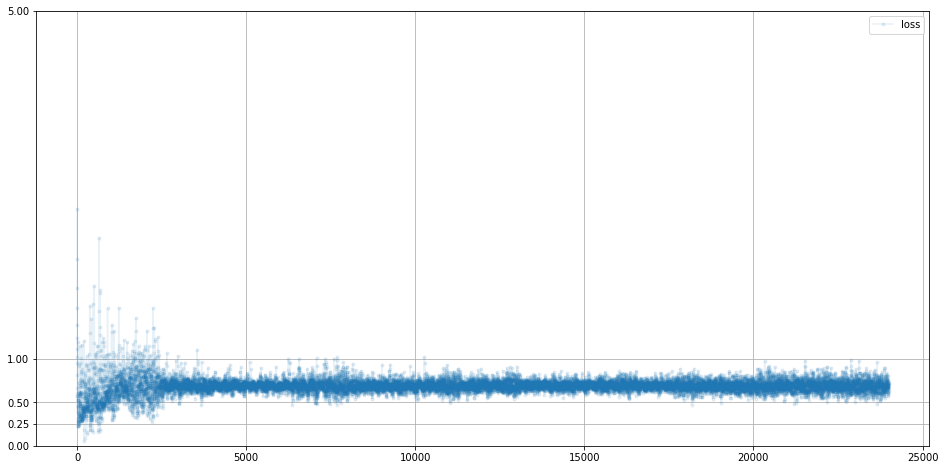

In [31]:
# plot discriminator loss
Dis.plot_progress()

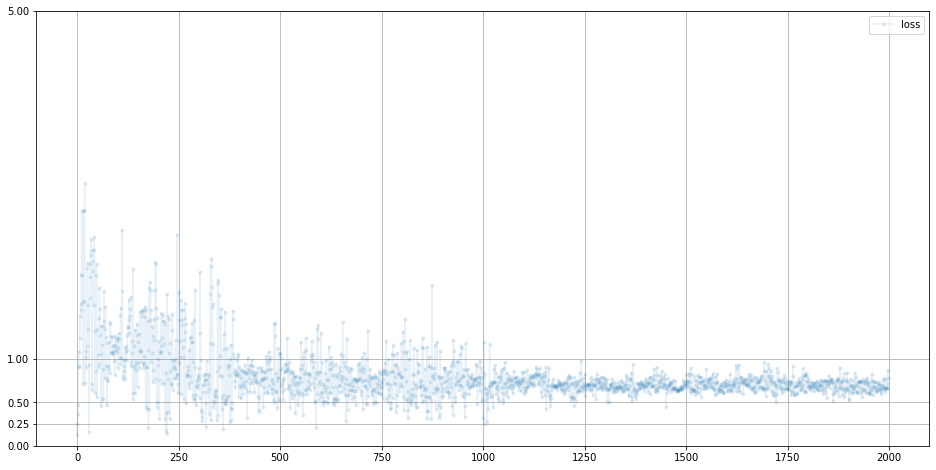

In [28]:
# plot generator loss
Gen.plot_progress()

Examining generated images

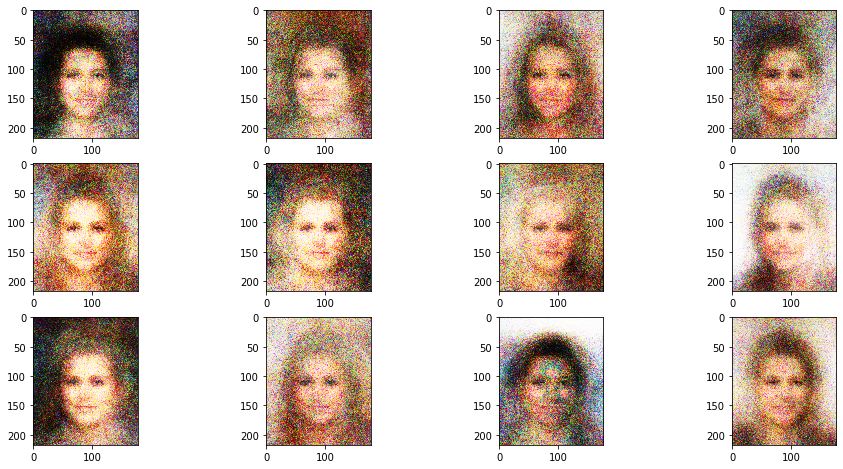

In [39]:
# plot 2 by 3 array of generated images
f, axarr = plt.subplots(3, 4, figsize=(16, 8))
for i in range(3):
    for j in range(4):
        output = Gen.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i, j].imshow(img, interpolation="none", cmap="Blues")